In [1]:
import pandas as pd
import ast
import numpy as np
from functools import partial
from tensorflow.keras.callbacks import EarlyStopping 
import tensorflow as tf
import keras
import random
from tensorflow.keras.models import load_model
from tensorflow.keras import layers, models
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense, BatchNormalization, GlobalAveragePooling2D
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid
from tensorflow.keras.layers import LSTM
from keras.layers import Reshape

from keras.layers import Lambda
import keras.backend as K
from keras.callbacks import ReduceLROnPlateau
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import regularizers

2023-10-07 16:40:25.740860: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## 1. Function to load and preprocess the data
Window size 100ms is chosen 

In [2]:
csv_file="data/avg_padded_truncated_mfcc_100ms.csv"      
data = pd.read_csv(csv_file)
num_mfccs = int(data['num_mfcc_values'][0])
mfcc_columns = [f'mfcc_{i}' for i in range(1, 14)]
X = np.array([data[mfcc_column].apply(eval).tolist() for mfcc_column in mfcc_columns])
# Reshape X to (number of instances, num_mfccs, 13, 1)

In [3]:
X = np.array([data[mfcc_column].apply(eval).tolist() for mfcc_column in mfcc_columns])

In [4]:
X = X.transpose(1, 0, 2)  # Transpose to (13, number_of_samples, reference_length)
X = X.reshape(-1, num_mfccs * 13) 
scaler = StandardScaler()
X= scaler.fit_transform(X)
X = X.reshape(-1, num_mfccs, 13)
y = data['label']

In [5]:
X.shape

(38392, 62, 13)

In [6]:
y.shape

(38392,)

In [7]:
def split_data(no_class, X,y):
    if no_class==2: # binary classification
        label_mapping = {'N': 0, 'S1': 1, 'S2':1, 'S3':1}
    else: 
        label_mapping = {'N': 0, 'S1': 1, 'S2':2, 'S3':3}
    y= y.replace(label_mapping)
    X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val= train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)
    return X_train, X_test, X_val, y_train, y_test, y_val 

## Function to create and fit CNN model

In [22]:
def create_fit_cnn(no_filters, kernel_sizes, activation, wht_init, lr, dr):
    
    if no_class==2: # binary classification
        units=1 # no of neurons in output layer
        output_activation='sigmoid' #sigmoid activation for binary classification
        loss='binary_crossentropy'
    else: 
        units=4
        output_activation='softmax' #Softmax activation for 4 class
        loss='sparse_categorical_crossentropy'
        
    DefaultConv2D = partial(layers.Conv2D, kernel_size=kernel_sizes, activation=activation, padding='same', kernel_regularizer=regularizers.l1_l2(0.001))
    cnn_model = models.Sequential([
        DefaultConv2D(filters=no_filters, kernel_size=kernel_sizes, input_shape=(num_mfccs, 13, 1)),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=2),

        DefaultConv2D(filters=no_filters*2),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=2), 
        
        layers.Flatten(),
        layers.Dropout(dr),
        
        layers.Dense(units=64, activation=activation, kernel_initializer=wht_init, kernel_regularizer=regularizers.l1_l2(0.001)),
        layers.BatchNormalization(),

        layers.Dense(units=units, activation=output_activation)
    ])
    optimizer = keras.optimizers.SGD(learning_rate=lr, momentum=0.9)
    # Compile the model with the given learning rate schedule
    cnn_model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    lr_scheduler_cb=keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)
    history = cnn_model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val),
                        callbacks=[early_stopping, lr_scheduler_cb])
    return cnn_model, history

## Function to create CNN+LSTM model

In [9]:
def create_fit_cnn_lstm(no_filters, kernel_sizes, activation, wht_init, lr, dr):
    if no_class == 2:  # binary classification
        units = 1  # number of neurons in the output layer
        output_activation = 'sigmoid'  # sigmoid activation for binary classification
        loss = 'binary_crossentropy'
    else:
        units = 4
        output_activation = 'softmax'  # softmax activation for multi-class
        loss = 'sparse_categorical_crossentropy'

    DefaultConv2D = partial(Conv2D, kernel_size=kernel_sizes, activation=activation, padding='same', kernel_regularizer=regularizers.l1(0.001))
    cnn_lstm_model = Sequential([
        DefaultConv2D(filters=no_filters, kernel_size=kernel_sizes, input_shape=(num_mfccs, 13, 1)),
        #BatchNormalization(),
        #MaxPooling2D(pool_size=2),
        
        # LSTM layers for sequence modeling
        Reshape(target_shape=(num_mfccs, 13 * no_filters)),
        LSTM(units=no_filters, return_sequences=True),
        LSTM(units=no_filters),

        Flatten(),
        Dropout(dr),
        
        Dense(units=128, activation=activation, kernel_initializer=wht_init,kernel_regularizer=regularizers.l1(0.001)),
        BatchNormalization(),
        Dense(units=units, activation=output_activation)
    ])

    optimizer = keras.optimizers.SGD(learning_rate=lr, momentum=0.9)
    
    cnn_lstm_model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    lr_scheduler_cb = ReduceLROnPlateau(factor=0.5, patience=5)

    history = cnn_lstm_model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val),
                                 callbacks=[early_stopping, lr_scheduler_cb])

    return cnn_lstm_model, history


## Function to plot learning curve

In [20]:
#function to plot accuracy, loss and learning rate
def plot_loss_accuracy(history):
    # Create a 1x3 grid of subplots
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # Plot Accuracy Curve
    axes[0].plot(history.history['accuracy'], 'r-', label='Training Accuracy')
    axes[0].plot(history.history['val_accuracy'], 'b-', label='Validation Accuracy')
    axes[0].set_xlabel("Epoch")
    axes[0].set_ylabel("Accuracy")
    axes[0].set_title("Accuracy Curve")
    axes[0].grid(True)
    axes[0].legend(loc="lower right")

    # Plot Loss Curve
    axes[1].plot(history.history['loss'], 'r-', label='Training Loss')
    axes[1].plot(history.history['val_loss'], 'b-', label='Validation Loss')
    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel("Loss")
    axes[1].set_title("Loss Curve")
    axes[1].grid(True)
    axes[1].legend(loc="upper right")
    
    # Plot Learning Rate Curve
    axes[2].plot(history.history['lr'], 'g-', label='Learning Rate')
    axes[2].set_xlabel("Epoch")
    axes[2].set_ylabel("Learning Rate")
    axes[2].set_title("Learning Rate Curve")
    axes[2].grid(True)
    axes[2].legend(loc="upper right")

    # Adjust spacing between subplots
    plt.tight_layout()
    # Show the combined plot
    plt.show()

## Function to print confusion Matrix

In [11]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
def print_conf_matrix(y_train, y_train_pred, y_test, y_test_pred, class_names):
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 10))
    plt.rc('font', size=9)
    ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, ax=axs[0], display_labels=class_names).im_.colorbar.remove()
    axs[0].set_title("Train set ")
    axs[0].tick_params(axis='x', labelrotation=90)
    plt.rc('font', size=9)
    ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred, ax=axs[1], display_labels=class_names).im_.colorbar.remove()
    axs[1].set_title("Test set ")
    axs[1].tick_params(axis='x', labelrotation=90)
    plt.show()

# Hyper parameter finetuning


In [12]:
no_class=4
X_train, X_test, X_val, y_train, y_test, y_val = split_data(no_class,X,y)

In [ ]:
X_train.shape

In [ ]:
X_val.shape

In [ ]:
from itertools import product

# Define a list of hyperparameter combinations to search
param_grid = {
    'no_filters': [32, 64],
    'kernel_sizes': [3, 5], 
    'wht_init': ["glorot_normal", "he_normal"],
    'dr': [0.2, 0.3],
    'lr': [0.01, 0.001],
    'activation': ['relu', 'selu'],
    # Add other hyperparameters here
}

best_score = 0
best_params = {}
count = 0

# Loop through hyperparameter combinations
for params in product(*param_grid.values()):
    count += 1
    no_filters, kernel_sizes, wht_init, dr, lr, activation = params
    print(f"Training model {count} with no_filters={no_filters}, kernel_sizes={kernel_sizes}, wht_init={wht_init}, dropout rate={dr}, learning rate={lr}, activation={activation}")
    model, history = create_fit_cnn(
        no_filters=no_filters,
        kernel_sizes=kernel_sizes,
        wht_init=wht_init,
        dr=dr,
        lr=lr,
        activation=activation
    )
    score = model.evaluate(X_val, y_val, verbose=0)[1]  # Get accuracy as the score
    
    # Check if this model's score is better than the previous best
    if score > best_score:
        best_score = score
        best_params = {
            'no_filters': no_filters,
            'kernel_sizes': kernel_sizes,
            'wht_init': wht_init,
            'dr': dr,
            'lr': lr,
            'activation': activation
        }

print(f"Best Parameters: {best_params}")
print(f"Best Score: {best_score}")

## Multiclass classification

### CNN only

In [23]:
no_class=4
X_train, X_test, X_val, y_train, y_test, y_val = split_data(no_class,X,y)
multi_cnn_model, multi_cnn_history = create_fit_cnn(32, 3, 'relu', 'glorot_normal', 0.001, 0.3)

Epoch 1/100
768/768 [==============================] - 31s 40ms/step - loss: 5.2223 - accuracy: 0.9094 - val_loss: 3.7500 - val_accuracy: 0.9473 - lr: 0.0010
Epoch 2/100
768/768 [==============================] - 29s 38ms/step - loss: 2.7919 - accuracy: 0.9433 - val_loss: 1.9680 - val_accuracy: 0.9482 - lr: 0.0010
Epoch 3/100
768/768 [==============================] - 30s 39ms/step - loss: 1.4321 - accuracy: 0.9444 - val_loss: 0.9799 - val_accuracy: 0.9543 - lr: 0.0010
Epoch 4/100
768/768 [==============================] - 29s 38ms/step - loss: 0.7614 - accuracy: 0.9453 - val_loss: 0.5749 - val_accuracy: 0.9508 - lr: 0.0010
Epoch 5/100
768/768 [==============================] - 27s 35ms/step - loss: 0.5072 - accuracy: 0.9416 - val_loss: 0.4821 - val_accuracy: 0.9266 - lr: 0.0010
Epoch 6/100
768/768 [==============================] - 26s 34ms/step - loss: 0.4278 - accuracy: 0.9422 - val_loss: 0.3612 - val_accuracy: 0.9591 - lr: 0.0010
Epoch 7/100
768/768 [==============================]

768/768 [==============================] - 30s 39ms/step - loss: 0.1698 - accuracy: 0.9669 - val_loss: 0.1634 - val_accuracy: 0.9694 - lr: 1.2500e-04
Epoch 53/100
768/768 [==============================] - 30s 39ms/step - loss: 0.1647 - accuracy: 0.9678 - val_loss: 0.1661 - val_accuracy: 0.9665 - lr: 1.2500e-04
Epoch 54/100
768/768 [==============================] - 30s 39ms/step - loss: 0.1613 - accuracy: 0.9678 - val_loss: 0.1721 - val_accuracy: 0.9648 - lr: 1.2500e-04
Epoch 55/100
768/768 [==============================] - 29s 38ms/step - loss: 0.1626 - accuracy: 0.9679 - val_loss: 0.1716 - val_accuracy: 0.9647 - lr: 1.2500e-04
Epoch 56/100
768/768 [==============================] - 28s 37ms/step - loss: 0.1666 - accuracy: 0.9660 - val_loss: 0.1926 - val_accuracy: 0.9556 - lr: 1.2500e-04
Epoch 57/100
768/768 [==============================] - 28s 36ms/step - loss: 0.1630 - accuracy: 0.9687 - val_loss: 0.1716 - val_accuracy: 0.9653 - lr: 1.2500e-04
Epoch 58/100
768/768 [=============

In [24]:
multi_cnn_model.save("multi_cnn_model", save_format="tf")

2023-10-07 21:17:24.517324: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,2880]
	 [[{{node inputs}}]]
2023-10-07 21:17:24.843623: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,2880]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: multi_cnn_model/assets


INFO:tensorflow:Assets written to: multi_cnn_model/assets


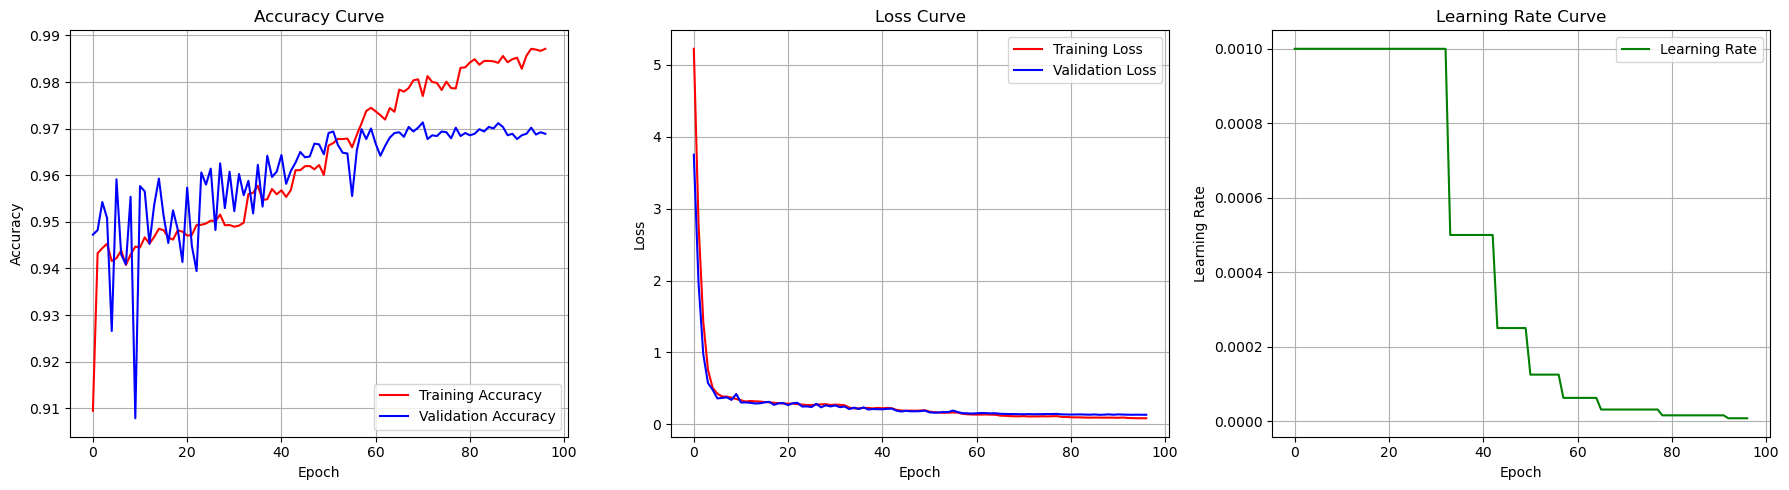

In [25]:
plot_loss_accuracy(multi_cnn_history)

In [26]:
y_train_pred_multi= multi_cnn_model.predict(X_train)
y_train_pred_multi = y_train_pred_multi.argmax(axis=-1)

y_test_pred_multi = multi_cnn_model.predict(X_test)
y_test_pred_multi = y_test_pred_multi.argmax(axis=-1)

240/240 [==============================] - 3s 14ms/step


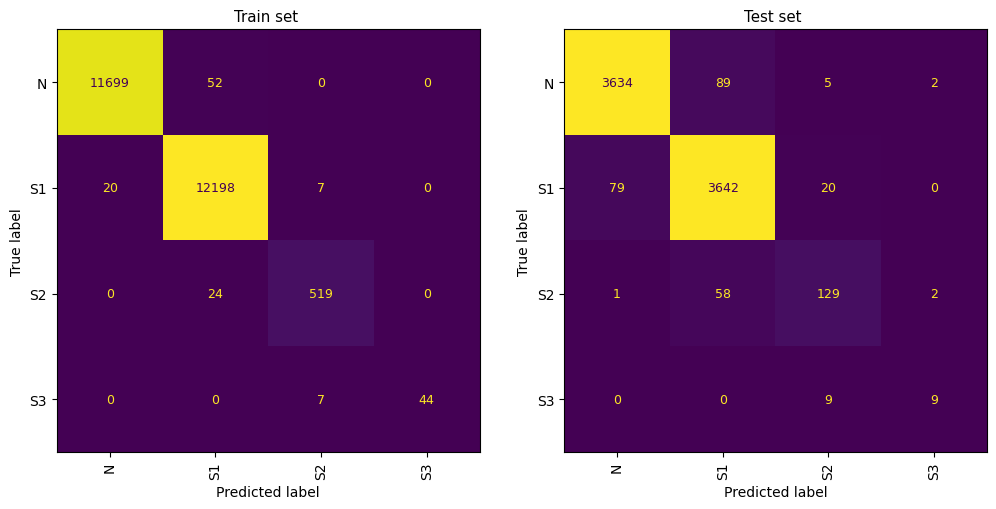

In [27]:
class_names=['N','S1','S2','S3']
print_conf_matrix(y_train, y_train_pred_multi, y_test, y_test_pred_multi, class_names)

### CNN+LSTM

In [28]:
multi_cnn_lstm, multi_cnn_lstm_history = create_fit_cnn_lstm(32, 3, 'relu', 'glorot_normal', 0.001, 0.3)
multi_cnn_lstm.save("multi_cnn_lstm", save_format="tf")

2023-10-07 21:18:09.042850: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-07 21:18:09.043833: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-07 21:18:09.044831: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/100


2023-10-07 21:18:09.494638: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-07 21:18:09.497033: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-07 21:18:09.498111: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

768/768 [==============================] - ETA: 0s - loss: 0.9536 - accuracy: 0.8025

2023-10-07 21:18:48.801465: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-07 21:18:48.803823: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-07 21:18:48.805500: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

768/768 [==============================] - 43s 52ms/step - loss: 0.9536 - accuracy: 0.8025 - val_loss: 0.8589 - val_accuracy: 0.8084 - lr: 0.0010
Epoch 2/100
768/768 [==============================] - 40s 52ms/step - loss: 0.7740 - accuracy: 0.8328 - val_loss: 0.7021 - val_accuracy: 0.8502 - lr: 0.0010
Epoch 3/100
768/768 [==============================] - 39s 51ms/step - loss: 0.7083 - accuracy: 0.8457 - val_loss: 0.6582 - val_accuracy: 0.8636 - lr: 0.0010
Epoch 4/100
768/768 [==============================] - 39s 51ms/step - loss: 0.6573 - accuracy: 0.8523 - val_loss: 0.6299 - val_accuracy: 0.8587 - lr: 0.0010
Epoch 5/100
768/768 [==============================] - 39s 51ms/step - loss: 0.6148 - accuracy: 0.8624 - val_loss: 0.5855 - val_accuracy: 0.8668 - lr: 0.0010
Epoch 6/100
768/768 [==============================] - 40s 52ms/step - loss: 0.5641 - accuracy: 0.8724 - val_loss: 0.9344 - val_accuracy: 0.6888 - lr: 0.0010
Epoch 7/100
768/768 [==============================] - 39s 51ms/

768/768 [==============================] - 42s 55ms/step - loss: 0.1191 - accuracy: 0.9670 - val_loss: 0.1512 - val_accuracy: 0.9551 - lr: 2.5000e-04
Epoch 53/100
768/768 [==============================] - 41s 53ms/step - loss: 0.1172 - accuracy: 0.9675 - val_loss: 0.1518 - val_accuracy: 0.9560 - lr: 2.5000e-04
Epoch 54/100
768/768 [==============================] - 41s 53ms/step - loss: 0.1160 - accuracy: 0.9670 - val_loss: 0.1558 - val_accuracy: 0.9547 - lr: 2.5000e-04
Epoch 55/100
768/768 [==============================] - 39s 51ms/step - loss: 0.1161 - accuracy: 0.9672 - val_loss: 0.1504 - val_accuracy: 0.9557 - lr: 2.5000e-04
Epoch 56/100
768/768 [==============================] - 40s 53ms/step - loss: 0.1159 - accuracy: 0.9676 - val_loss: 0.1646 - val_accuracy: 0.9515 - lr: 2.5000e-04
Epoch 57/100
768/768 [==============================] - 40s 53ms/step - loss: 0.1173 - accuracy: 0.9667 - val_loss: 0.1507 - val_accuracy: 0.9552 - lr: 2.5000e-04
Epoch 58/100
768/768 [=============

2023-10-07 22:02:12.462164: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-07 22:02:12.463336: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-07 22:02:12.464689: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2023-10-07 22:02:13.546413: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-07 22:02:13.547402: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-07 22:02:13.548475: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2023-10-07 22:02:14.885372: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-07 22:02:14.886476: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-07 22:02:14.887643: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2023-10-07 22:02:16.071554: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-07 22:02:16.072511: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-07 22:02:16.073524: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

INFO:tensorflow:Assets written to: multi_cnn_lstm/assets


INFO:tensorflow:Assets written to: multi_cnn_lstm/assets


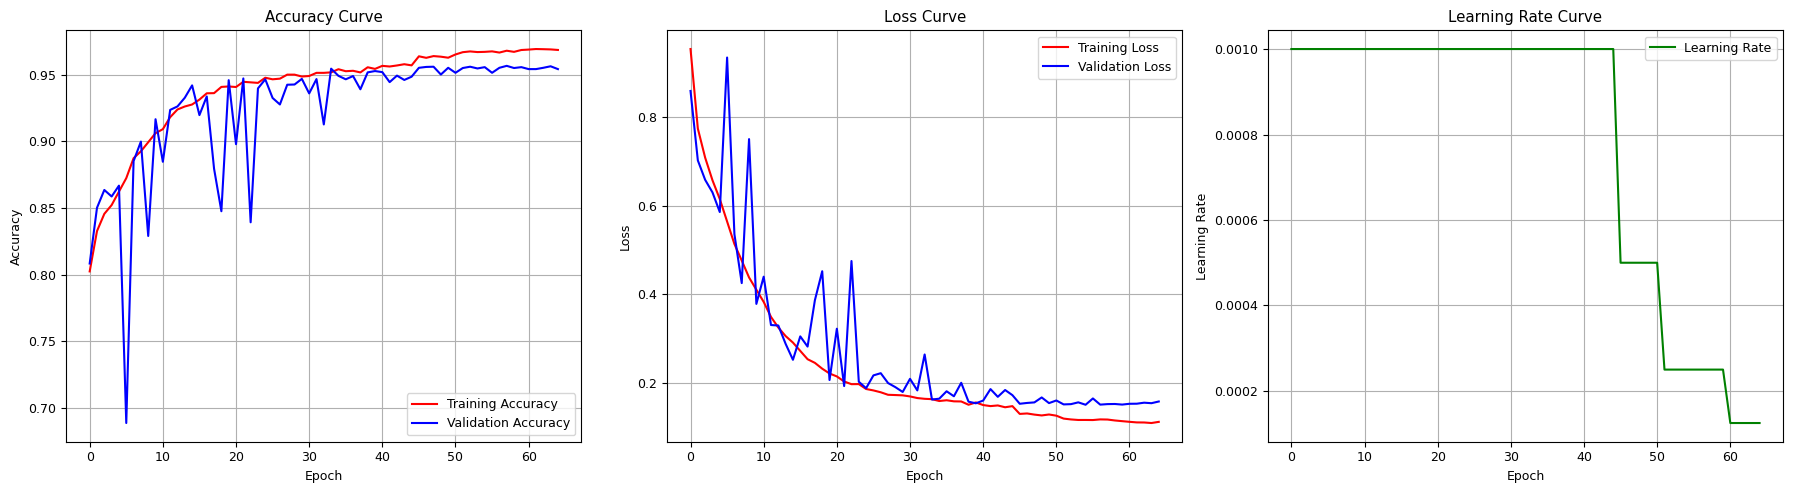

In [29]:
plot_loss_accuracy(multi_cnn_lstm_history)

In [30]:
y_train_pred_multi_lstm= multi_cnn_lstm.predict(X_train)
y_train_pred_multi_lstm = y_train_pred_multi_lstm.argmax(axis=-1)

y_test_pred_multi_lstm = multi_cnn_lstm.predict(X_test)
y_test_pred_multi_lstm = y_test_pred_multi_lstm.argmax(axis=-1)

2023-10-07 22:02:17.930929: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-07 22:02:17.932123: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-07 22:02:17.933300: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

240/240 [==============================] - 3s 14ms/step


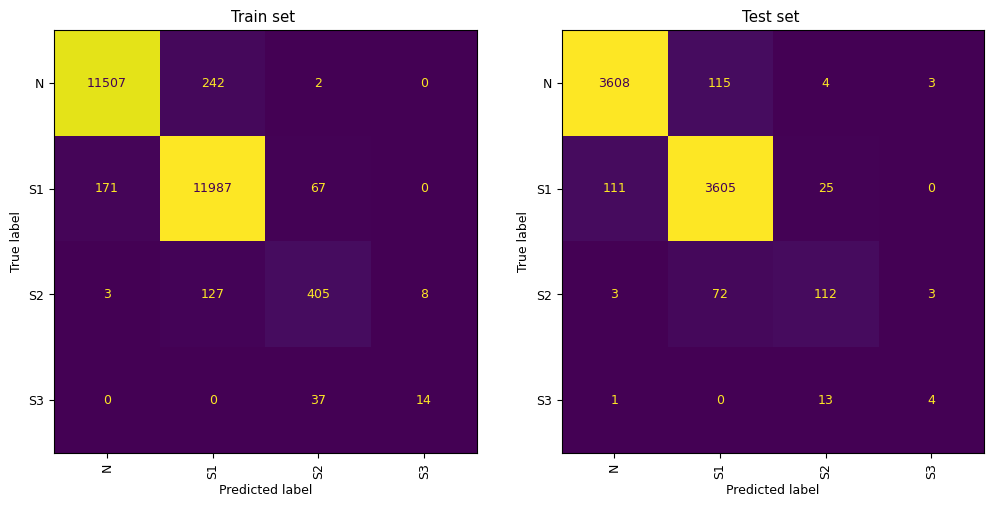

In [31]:
class_names=['N','S1','S2','S3']
print_conf_matrix(y_train, y_train_pred_multi_lstm, y_test, y_test_pred_multi_lstm, class_names)

## Binary Classification

In [32]:
no_class=2
X_train, X_test, X_val, y_train, y_test, y_val = split_data(no_class,X,y)

In [33]:
X_train.shape

(24570, 62, 13)

### CNN Only

In [34]:
bin_cnn_model, bin_cnn_history = create_fit_cnn(32, 3, 'relu', 'glorot_normal', 0.001, 0.3)
bin_cnn_model.save("bin_cnn_model", save_format="tf")

Epoch 1/100
768/768 [==============================] - 28s 35ms/step - loss: 5.1015 - accuracy: 0.9352 - val_loss: 3.6963 - val_accuracy: 0.9604 - lr: 0.0010
Epoch 2/100
768/768 [==============================] - 26s 34ms/step - loss: 2.7186 - accuracy: 0.9564 - val_loss: 1.8730 - val_accuracy: 0.9674 - lr: 0.0010
Epoch 3/100
768/768 [==============================] - 27s 35ms/step - loss: 1.3356 - accuracy: 0.9624 - val_loss: 0.8935 - val_accuracy: 0.9665 - lr: 0.0010
Epoch 4/100
768/768 [==============================] - 27s 35ms/step - loss: 0.6597 - accuracy: 0.9590 - val_loss: 0.4702 - val_accuracy: 0.9653 - lr: 0.0010
Epoch 5/100
768/768 [==============================] - 27s 35ms/step - loss: 0.3936 - accuracy: 0.9584 - val_loss: 0.3155 - val_accuracy: 0.9630 - lr: 0.0010
Epoch 6/100
768/768 [==============================] - 30s 38ms/step - loss: 0.3047 - accuracy: 0.9575 - val_loss: 0.3163 - val_accuracy: 0.9469 - lr: 0.0010
Epoch 7/100
768/768 [==============================]

Epoch 52/100
768/768 [==============================] - 29s 38ms/step - loss: 0.0864 - accuracy: 0.9859 - val_loss: 0.1082 - val_accuracy: 0.9780 - lr: 3.1250e-05
Epoch 53/100
768/768 [==============================] - 29s 38ms/step - loss: 0.0849 - accuracy: 0.9868 - val_loss: 0.1037 - val_accuracy: 0.9779 - lr: 3.1250e-05
Epoch 54/100
768/768 [==============================] - 28s 36ms/step - loss: 0.0847 - accuracy: 0.9863 - val_loss: 0.1032 - val_accuracy: 0.9782 - lr: 3.1250e-05
Epoch 55/100
768/768 [==============================] - 29s 37ms/step - loss: 0.0865 - accuracy: 0.9851 - val_loss: 0.1024 - val_accuracy: 0.9783 - lr: 3.1250e-05
Epoch 56/100
768/768 [==============================] - 27s 36ms/step - loss: 0.0831 - accuracy: 0.9869 - val_loss: 0.1057 - val_accuracy: 0.9766 - lr: 3.1250e-05
Epoch 57/100
768/768 [==============================] - 29s 38ms/step - loss: 0.0829 - accuracy: 0.9866 - val_loss: 0.1017 - val_accuracy: 0.9797 - lr: 3.1250e-05
Epoch 58/100
768/768 [

2023-10-07 22:48:48.119811: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,2880]
	 [[{{node inputs}}]]
2023-10-07 22:48:48.421213: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,2880]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: bin_cnn_model/assets


INFO:tensorflow:Assets written to: bin_cnn_model/assets


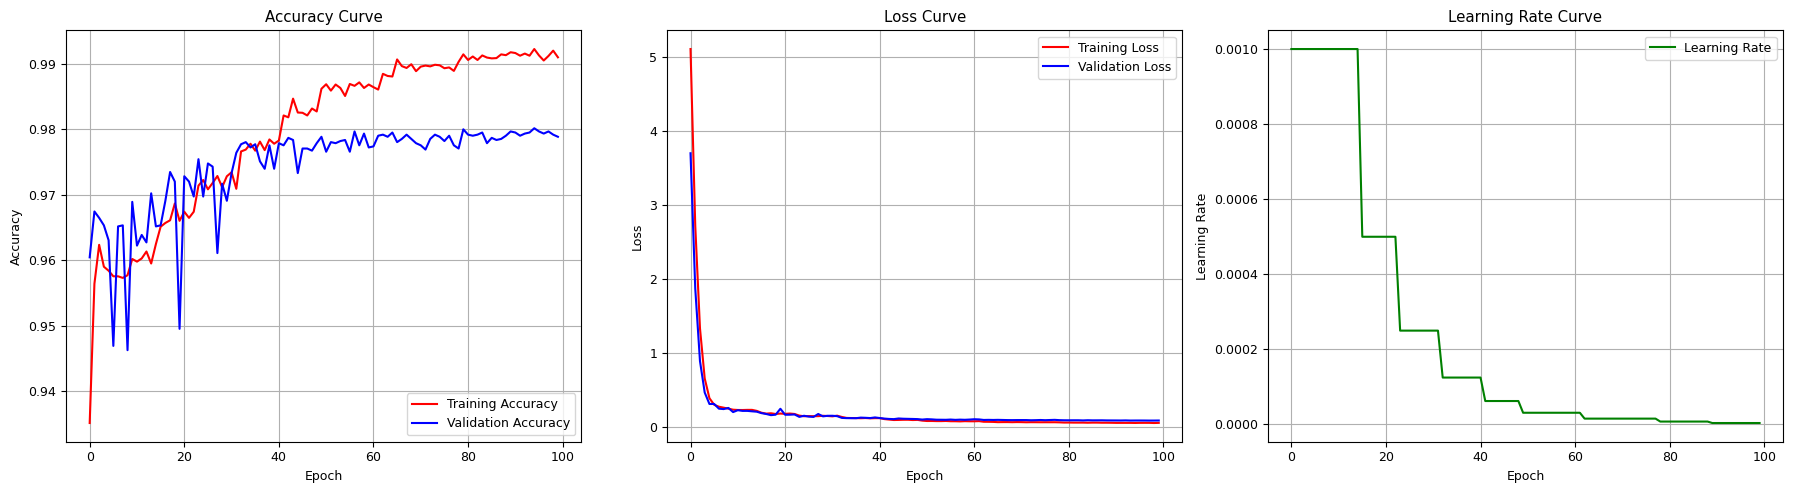

In [35]:
plot_loss_accuracy(bin_cnn_history)

In [36]:
y_train_pred_bin = bin_cnn_model.predict(X_train)
y_test_pred_bin = bin_cnn_model.predict(X_test)

y_train_pred_bin = (y_train_pred_bin >= 0.5).astype(int)
y_test_pred_bin = (y_test_pred_bin >= 0.5).astype(int)

240/240 [==============================] - 3s 14ms/step


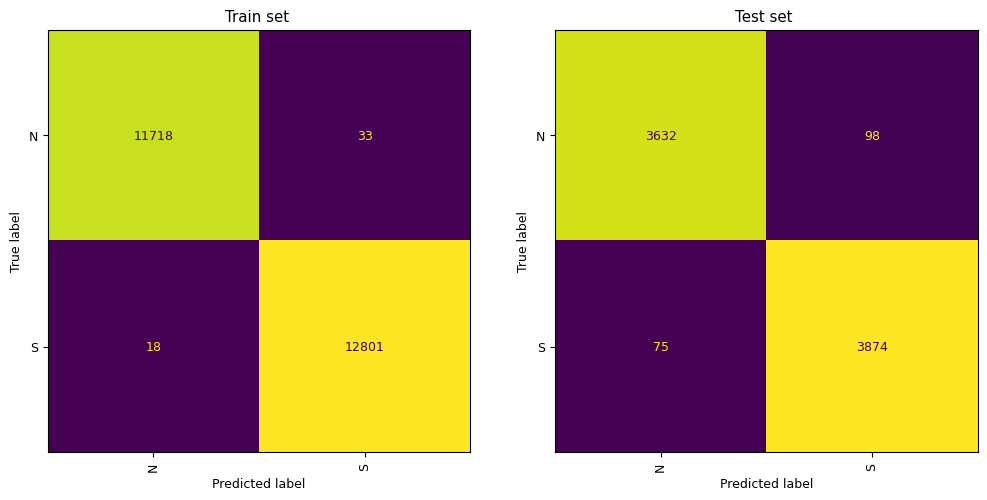

In [37]:
class_names=['N','S']
print_conf_matrix(y_train, y_train_pred_bin, y_test, y_test_pred_bin, class_names)

### CNN + LSTM

In [38]:
bin_cnn_lstm, bin_cnn_lstm_history = create_fit_cnn(32, 3, 'relu', 'glorot_normal', 0.001, 0.3)
bin_cnn_lstm.save("bin_cnn_lstm", save_format="tf")

Epoch 1/100
768/768 [==============================] - 28s 36ms/step - loss: 5.1131 - accuracy: 0.9357 - val_loss: 3.6979 - val_accuracy: 0.9657 - lr: 0.0010
Epoch 2/100
768/768 [==============================] - 28s 37ms/step - loss: 2.7217 - accuracy: 0.9617 - val_loss: 1.8723 - val_accuracy: 0.9700 - lr: 0.0010
Epoch 3/100
768/768 [==============================] - 28s 37ms/step - loss: 1.3449 - accuracy: 0.9625 - val_loss: 0.9012 - val_accuracy: 0.9642 - lr: 0.0010
Epoch 4/100
768/768 [==============================] - 28s 37ms/step - loss: 0.6632 - accuracy: 0.9612 - val_loss: 0.4835 - val_accuracy: 0.9573 - lr: 0.0010
Epoch 5/100
768/768 [==============================] - 28s 37ms/step - loss: 0.4027 - accuracy: 0.9588 - val_loss: 0.3134 - val_accuracy: 0.9735 - lr: 0.0010
Epoch 6/100
768/768 [==============================] - 29s 38ms/step - loss: 0.3096 - accuracy: 0.9582 - val_loss: 0.2775 - val_accuracy: 0.9606 - lr: 0.0010
Epoch 7/100
768/768 [==============================]

Epoch 52/100
768/768 [==============================] - 26s 34ms/step - loss: 0.1196 - accuracy: 0.9794 - val_loss: 0.1240 - val_accuracy: 0.9774 - lr: 1.2500e-04
Epoch 53/100
768/768 [==============================] - 26s 34ms/step - loss: 0.1211 - accuracy: 0.9787 - val_loss: 0.1285 - val_accuracy: 0.9754 - lr: 1.2500e-04
Epoch 54/100
768/768 [==============================] - 26s 33ms/step - loss: 0.1235 - accuracy: 0.9775 - val_loss: 0.1452 - val_accuracy: 0.9692 - lr: 1.2500e-04
Epoch 55/100
768/768 [==============================] - 25s 33ms/step - loss: 0.1100 - accuracy: 0.9820 - val_loss: 0.1175 - val_accuracy: 0.9788 - lr: 6.2500e-05
Epoch 56/100
768/768 [==============================] - 27s 35ms/step - loss: 0.1035 - accuracy: 0.9825 - val_loss: 0.1139 - val_accuracy: 0.9780 - lr: 6.2500e-05
Epoch 57/100
768/768 [==============================] - 27s 35ms/step - loss: 0.1041 - accuracy: 0.9818 - val_loss: 0.1132 - val_accuracy: 0.9772 - lr: 6.2500e-05
Epoch 58/100
768/768 [

2023-10-07 23:33:55.422700: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,2880]
	 [[{{node inputs}}]]
2023-10-07 23:33:55.733671: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,2880]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: bin_cnn_lstm/assets


INFO:tensorflow:Assets written to: bin_cnn_lstm/assets


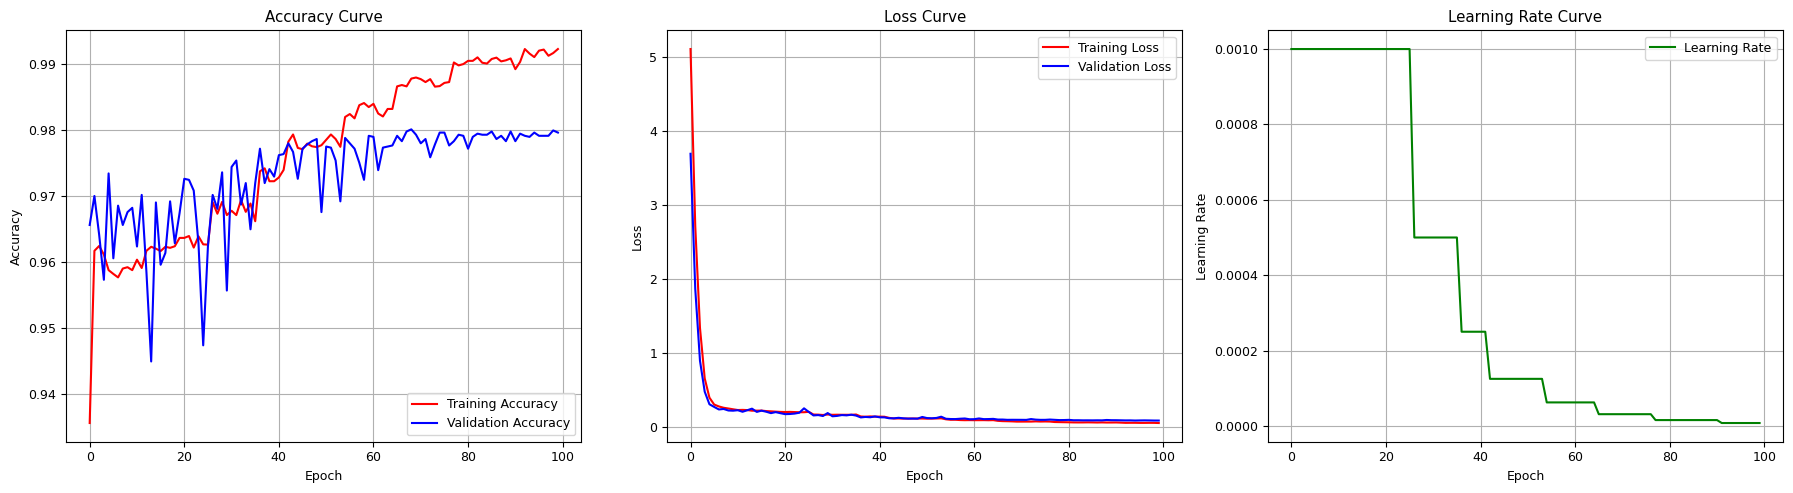

In [39]:
plot_loss_accuracy(bin_cnn_lstm_history)

In [40]:
y_train_pred_bin_lstm = bin_cnn_lstm.predict(X_train)
y_test_pred_bin_lstm = bin_cnn_lstm.predict(X_test)
y_train_pred_bin_lstm = (y_train_pred_bin_lstm >= 0.5).astype(int)
y_test_pred_bin_lstm = (y_test_pred_bin_lstm >= 0.5).astype(int)

240/240 [==============================] - 3s 13ms/step


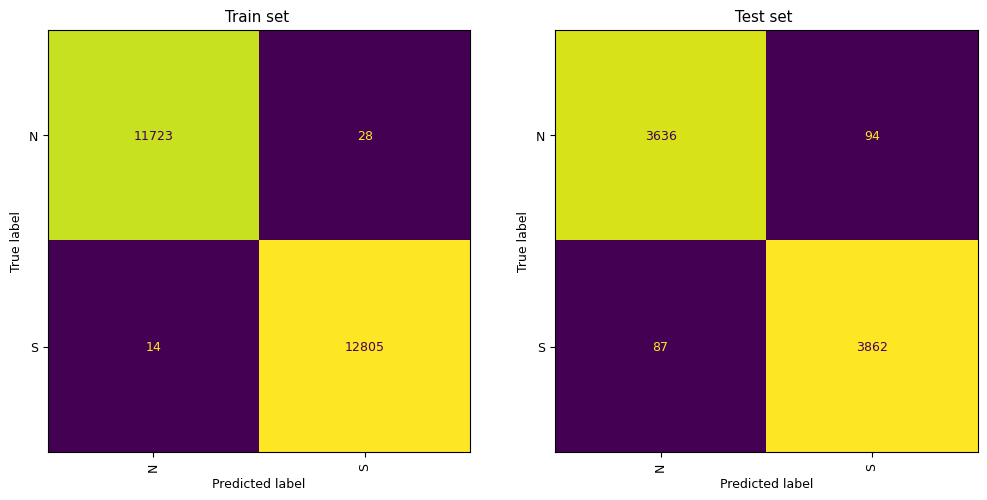

In [41]:
class_names=['N','S']
print_conf_matrix(y_train, y_train_pred_bin_lstm, y_test, y_test_pred_bin_lstm, class_names)

## Model Comparision

In [42]:
from sklearn.metrics import accuracy_score, f1_score
def cal_scores (y_true, y_pred):
    return  f1_score(y_true,y_pred, average="macro"), accuracy_score(y_true,y_pred)

In [43]:
train_f1_multi, train_accuracy_multi = cal_scores(y_train, y_train_pred_multi)
test_f1_multi, test_accuracy_multi = cal_scores(y_test, y_test_pred_multi)

In [44]:
train_f1_multi_lstm, train_accuracy_multi_lstm = cal_scores(y_train, y_train_pred_multi_lstm)
test_f1_multi_lstm, test_accuracy_multi_lstm = cal_scores(y_test, y_test_pred_multi_lstm)

In [45]:
train_f1_bin, train_accuracy_bin = cal_scores(y_train, y_train_pred_bin)
test_f1_bin, test_accuracy_bin = cal_scores(y_test, y_test_pred_bin)

In [46]:
train_f1_bin_lstm, train_accuracy_bin_lstm = cal_scores(y_train, y_train_pred_bin_lstm)
test_f1_bin_lstm, test_accuracy_bin_lstm = cal_scores(y_test, y_test_pred_bin_lstm)

### Comparing Accuracies

In [47]:
print("Accuracy Comparision")
accuracy_metrics = {
    "Data Set": ["Multiclass_CNN", "Multiclass_CNN+LSTM", "Binary_CNN", "Binary_CNN+LSTM"],
    "Training Set": [f"{train_accuracy_multi:.2%}", f"{train_accuracy_multi_lstm:.2%}", f"{train_accuracy_bin:.2%}", f"{train_accuracy_bin_lstm:.2%}"],
    "Test Set": [f"{test_accuracy_multi:.2%}", f"{test_accuracy_multi_lstm:.2%}",f"{test_accuracy_bin:.2%}", f"{test_accuracy_bin_lstm:.2%}"]}
accuracy_metrics_df = pd.DataFrame(accuracy_metrics)
accuracy_metrics_df = accuracy_metrics_df.transpose()
accuracy_metrics_df

Accuracy Comparision


,0,1,2,3
Data Set,Multiclass_CNN,Multiclass_CNN+LSTM,Binary_CNN,Binary_CNN+LSTM
Training Set,97.36%,96.14%,99.79%,99.83%
Test Set,95.51%,94.87%,97.75%,97.64%


### Comparing F1 Scores

In [48]:
print("F1 Score Comparision")
f1_metrics = {
    "Data Set": ["Multiclass_CNN", "Multiclass_CNN+LSTM", "Binary_CNN", "Binary_CNN+lstm"],
    "Training Set": [f"{train_f1_multi:.2%}", f"{train_f1_multi_lstm:.2%}", f"{train_f1_bin:.2%}", f"{train_f1_bin_lstm:.2%}"],
    "Test Set": [f"{test_f1_multi:.2%}", f"{test_f1_multi_lstm:.2%}",f"{test_f1_bin:.2%}", f"{test_f1_bin_lstm:.2%}"]}
f1_metrics_df = pd.DataFrame(f1_metrics)
f1_metrics_df = f1_metrics_df.transpose()
f1_metrics_df

F1 Score Comparision


,0,1,2,3
Data Set,Multiclass_CNN,Multiclass_CNN+LSTM,Binary_CNN,Binary_CNN+lstm
Training Set,49.28%,48.61%,99.79%,99.83%
Test Set,48.32%,47.96%,97.74%,97.64%
